[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [3]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 specific study areas that are all related to this overall course topic: {topic}."""
study_tip_prompt = """Generate a practical and effective study tip for Akshat about {subject}"""
best_tip_prompt = """Below are a bunch of study tips about {topic}. Select the most actionable and effective one! Return the ID of the best one, starting 0 as the ID for the first tip. Study tips: \n\n  {study_tips}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)


## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [4]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestStudyTip(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    study_tips: Annotated[list, operator.add]
    best_selected_tip: str


Generate subjects for jokes.

In [5]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a study tip for each subject.

This is very useful! It can automatically parallelize study tip generation for any number of subjects.

* `generate_study_tip`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_study_tip`! It does not have to align with `OverallState`.

In this case, `generate_study_tip` is using its own internal state, and we can populate this via `Send`.


In [6]:
from langgraph.types import Send
def continue_to_study_tips(state: OverallState):
    return [Send("generate_study_tip", {"subject": s}) for s in state["subjects"]]


### Study tip generation (map)

Now, we just define a node that will create our study tips, `generate_study_tip`!

We write them back out to `study_tips` in `OverallState`! 

This key has a reducer that will combine lists.


In [7]:
class StudyTipState(TypedDict):
    subject: str

class StudyTip(BaseModel):
    study_tip: str

def generate_study_tip(state: StudyTipState):
    prompt = study_tip_prompt.format(subject=state["subject"])
    response = model.with_structured_output(StudyTip).invoke(prompt)
    return {"study_tips": [response.study_tip]}


### Best study tip selection (reduce)

Now, we add logic to pick the best study tip.


In [8]:
def best_study_tip(state: OverallState):
    study_tips = "\n\n".join(state["study_tips"])
    prompt = best_tip_prompt.format(topic=state["topic"], study_tips=study_tips)
    response = model.with_structured_output(BestStudyTip).invoke(prompt)
    return {"best_selected_tip": state["study_tips"][response.id]}


## Compile

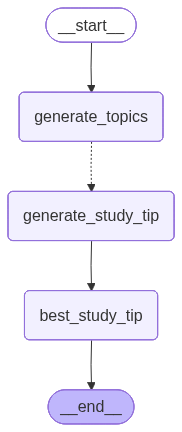

In [9]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_study_tip", generate_study_tip)
graph.add_node("best_study_tip", best_study_tip)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_study_tips, ["generate_study_tip"])
graph.add_edge("generate_study_tip", "best_study_tip")
graph.add_edge("best_study_tip", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())


In [10]:
# Call the graph: here we call it to generate a list of study tips
for s in app.stream({"topic": "LangGraph and Multi-Agent Systems"}):
    print(s)


{'generate_topics': {'subjects': ['Natural Language Processing in Multi-Agent Systems', 'Graph Theory Applications in Multi-Agent Communication', 'Distributed Artificial Intelligence and Coordination in Multi-Agent Systems']}}
{'generate_study_tip': {'study_tips': ["### Study Tip: Mastering Distributed AI and Multi-Agent Coordination\n\n**1. Break Down the Concepts:**\n   - **Distributed AI:** Understand the basics of distributed systems, including how tasks are divided and processed across multiple agents.\n   - **Multi-Agent Systems (MAS):** Learn about the architecture, communication protocols, and decision-making processes in MAS.\n\n**2. Use Real-World Analogies:**\n   - Think of multi-agent systems like a team of robots working together to complete a task, each with its own role but needing to coordinate with others.\n\n**3. Leverage Visual Aids:**\n   - Create diagrams to map out how agents interact and share information. Visualizing the flow of data and decision-making can clar

## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.